In [33]:
!pip install keras

In [0]:
# The essentials
import pandas as pd
import numpy as np

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython.display import clear_output

# Progress bars
from tqdm import tqdm_notebook

import pickle
from time import time

import keras.backend as K
from keras import models, layers, optimizers, callbacks

# Access our Google Drive
from google.colab import drive

In [0]:
import tensorflow as tf
import keras

config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [36]:
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/Rinse Over Run"

Mounted at /content/drive
20178.png
20451.png
20899.png
22112.png
22369.png
22414.png
22487.png
23011.png
23142.png
23599.png
23872.png
24804.png
24845.png
24872.png
25129.png
25908.png
25983.png
26270.png
27115.png
27243.png
27346.png
27366.png
27418.png
27508.png
all_train_preds_per_phase.p
baseline_features_with_preds_per_phase.csv
baseline_model_per_nunique_phases.csv
dtw_distances_3.p
mds_embeddings_2d_3.csv
mds_embeddings_2d_3.p
more_features_with_preds_per_phase.csv
pca_features_with_preds_per_phase.csv
predictions_machine_405.csv
test_features_14.csv
test_features_15.csv
test_features_1.csv
test_features_2.csv
test_features_3.csv
test_features_6.csv
test_features_7.csv
test_features_8.csv
test_features_per_phase_14.csv
test_features_per_phase_15.csv
test_features_per_phase_1.csv
test_features_per_phase_2.csv
test_features_per_phase_3.csv
test_features_per_phase_6.csv
test_features_per_phase_7.csv
test_features_per_phase_8.csv
test_preds_per_phase.p
test_values.csv
train_feature

In [0]:
def filter_data(raw_data, processes, phases, columns):
    filtered_data = raw_data[(raw_data['process_id'].isin(processes)) & 
                             (raw_data['phase'].isin(phases))][['process_id', 'timestamp'] + columns]
    filtered_data = filtered_data.reset_index(drop=True)
    return filtered_data
  
  
def get_fourier_coefs(data, processes, cols, n_coefs=100):
  all_fft_coefs = np.zeros((len(processes), n_coefs, len(cols)))
  for process_ix, process in enumerate(processes):
    filtered_data = data[data['process_id'] == process]
    filtered_data = filtered_data.sort_values(by='timestamp')
    filtered_data = filtered_data.reset_index(drop=True)
    filtered_data = filtered_data[cols].astype(float)
    
    
    fft_coefs = np.zeros((n_coefs, len(cols)))
    for col_ix, col in enumerate(cols):
      fft_coefs[:, col_ix] = np.abs(np.fft.fft(filtered_data[col].values, n=n_coefs))
    
    all_fft_coefs[process_ix, :, :] = fft_coefs
    
  return all_fft_coefs

In [0]:
PROCESS_COMBINATION = 15

phases = {
    15: ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid'],
    3:  ['pre_rinse', 'caustic'],
    7:  ['pre_rinse', 'caustic', 'intermediate_rinse'],
    1:  ['pre_rinse'],
    8:  ['acid'],
    2:  ['caustic'],
    6:  ['caustic', 'intermediate_rinse'],
    14: ['caustic', 'intermediate_rinse', 'acid'],
}

ts_cols = [
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
    'supply_pump',
    'supply_pre_rinse',
    'supply_caustic',
    'return_caustic',
    'supply_acid',
    'return_acid',
    'supply_clean_water',
    'return_recovery_water',
    'return_drain',
    'object_low_level'
]

In [43]:
train_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_values.csv', index_col=0, parse_dates=['timestamp'])
labels = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_labels.csv', index_col=0)

processes_all_phases = pickle.load(open('/content/drive/My Drive/Rinse Over Run/processes_all_phases.p', 'rb'))

val_procs = list(np.random.choice(processes_all_phases, replace=False, size=int(0.1*len(processes_all_phases))))
train_procs = list(set(processes_all_phases) - set(val_procs))

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
# Uncomment for subsampling

#train_procs = np.random.choice(list(train_procs), replace=False, size=250)
#val_procs = np.random.choice(list(val_procs), replace=False, size=250)

In [44]:
filtered_data = filter_data(train_df, train_procs, phases[PROCESS_COMBINATION], ts_cols)
train_fourier_coefs = get_fourier_coefs(filtered_data, train_procs, ts_cols)
train_labels = np.log(labels.loc[train_procs].values)

filtered_data = filter_data(train_df, val_procs, phases[PROCESS_COMBINATION], ts_cols)
val_fourier_coefs = get_fourier_coefs(filtered_data, val_procs, ts_cols)
val_labels = np.log(labels.loc[val_procs].values)

print(train_fourier_coefs.shape, val_fourier_coefs.shape)

(3354, 100, 25) (372, 100, 25)


In [0]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
def custom_mape_exp(y_true,y_pred):  # Werkt niet (evt wel met mean_absolute_percentage_error)
    y_true = K.exp(y_true)
    y_pred = K.exp(y_pred)
    
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),
                                            290000,
                                            None))
    return 100. * K.mean(diff, axis=-1)

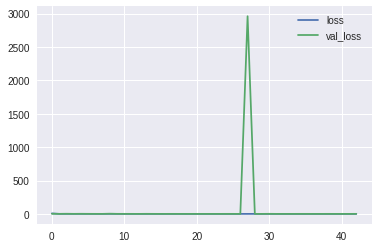

Epoch 44/1000
 736/3354 [=====>........................] - ETA: 11s - loss: 0.7108

KeyboardInterrupt: ignored

In [52]:
model = models.Sequential()

model.add(layers.Conv1D(128, 7, activation='relu', input_shape=(100, len(ts_cols))))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling1D(2))

model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling1D(2))

model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling1D(2))

model.add(layers.Flatten())
#model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.Adam(lr=0.01), loss='mean_squared_error')

print(model.summary())

model.fit(train_fourier_coefs, train_labels, batch_size=16, verbose=1,
          epochs=1000, validation_data=(val_fourier_coefs, val_labels),
          callbacks=[PlotLosses(), callbacks.EarlyStopping(patience=100)])#callbacks.EarlyStopping(patience=100)

print(custom_mape_exp(model.predict(X_val), y_val))